# Машинное обучение
## Лабораторная работа №3

Выполнил студент группы 19-ИВТ-3   
Сухоруков В.А.   
Вариант №9

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
df = pd.read_csv('titanic3.csv', sep=';')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,23,1,2,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
df.shape

(1309, 14)

In [4]:
df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|pclass        |класс билета  |1 - 1 класс; 2 -  2 класс; 3 -  3 класс |
|survived| выживание| 0 - Нет ;1 - Да|
|name|имя|любой|
|sex|пол|female - женский, male - мужской|
|age|возраст|любой числовой|
|sibsp|число братьев, сестер, супругов на борту|любой числовой|
|parch|число родителей, детей на ботру|любой числовой|
|fare|цена билета(британский фунт)|любой числовой|
|ticket|номер билета|любой|
|cabin|номер каюты|любой|
|embarked|порт погрузки|C = Cherbourg, Q = Queenstown, S = Southampton|
|boat|номер спасательной шлюпки|любой|
|body|идентификационный номер тела|любой|
|home.dest|Дом/Назначение|любой|    

**Задача: по данным признакам предсказать, выживет ли пасажир.**     

При решении задачи некоторые признаки будут лишними. К ним можно отнести:
 - body, так как по его наличию id тела однозначно видно, что человек умер, а само значение ни о чем не говорит.  
 - boat, тоже самое можно сказать про номер шлюпки - если он есть, то человек спасен.     
 - ticket, так как номер билета ни о чем не говорит.     
 - cabin, это поле слабо заполнено, и восстановить его правильно не получится.
 - home.dst, также слишком слабо заполнено.
 - name, имя точно не влияет на спасение человка.

In [5]:
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29,0,0,"211,3375",S
1,1,1,male,23,1,2,"151,5500",S
2,1,0,female,2,1,2,"151,5500",S
3,1,0,male,30,1,2,"151,5500",S
4,1,0,female,25,1,2,"151,5500",S


In [6]:
df.count()

pclass      1309
survived    1309
sex         1309
age         1046
sibsp       1309
parch       1309
fare        1308
embarked    1307
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [7]:
df = df.drop_duplicates()
df.shape

(1114, 8)

In [8]:
df.count()

pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

### 3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

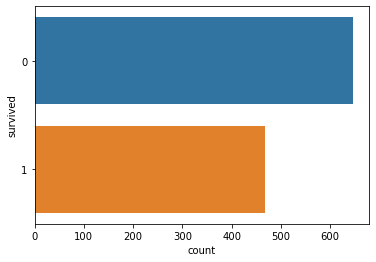

In [9]:
sns.countplot(data=df, y='survived')
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.    
Будем использовать PR-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы.

### 4)  Выполните масштабирование количественных признаков

In [10]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)


numerical:  ['pclass', 'survived', 'sibsp', 'parch']
categorial:  ['sex', 'age', 'fare', 'embarked']


age и fare по форме должны быть числовыми, но из-за разделителя дробной части ввиде запятой, питон видит их как строки. Преобразуем их к числовому виду

In [11]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj

df['age'] = df['age'].apply(lambda x: cast(x))
df['fare'] = df['fare'].apply(lambda x: cast(x))



pclass должен относиться к категориальным признакам, а не количественным (не должно быть так, чтобы 1-ый и 2-ой классы в сумме давали 3-ий)

In [12]:
df['pclass'] = df['pclass'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


sklearn не работает с пустыми значениями, поэтому заполним/выбросим их

In [13]:
# заполним пропущенные значения параметра age медианными,
# чтобы не потерять много данных при очистке строк с пустыми полями
df['age'] = df['age'].fillna(df['age'].median())
df = df.dropna().reset_index(drop=True)
df.count()

pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

<AxesSubplot:>

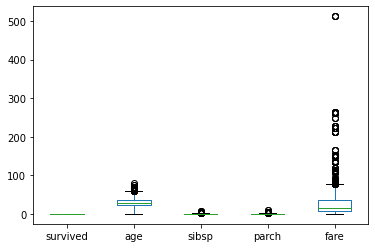

In [14]:
df[numerical_columns].plot.box()

In [15]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1,1.0,male,0.286012,0.125,0.222222,0.295806,S
2,1,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1,0.0,female,0.311064,0.125,0.222222,0.295806,S


<AxesSubplot:>

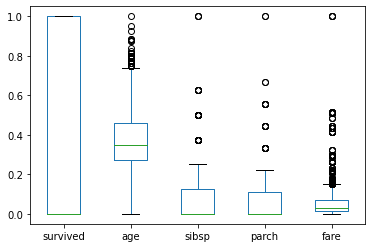

In [16]:
df[numerical_columns].plot.box()

### 5) Выполните замену категориальных признаков

In [17]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

pclass :  ['1' '2' '3']
sex :  ['female' 'male']
embarked :  ['S' 'C' 'Q']


In [18]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(1111, 12)


,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.286012,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

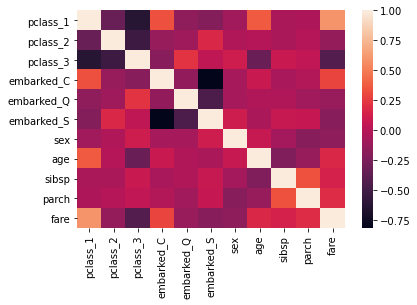

In [19]:
df_corr = df.drop('survived', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [20]:
df_corr

,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex,age,sibsp,parch,fare
pclass_1,1.000000,-0.328892,-0.627709,0.334279,-0.159778,-0.208995,-0.085627,0.369656,-0.042350,-0.038106,0.596881
pclass_2,-0.328892,1.000000,-0.528693,-0.132455,-0.096509,0.176612,-0.027632,-0.009779,-0.049192,-0.010906,-0.139155
pclass_3,-0.627709,-0.528693,1.000000,-0.191272,0.223164,0.042266,0.099741,-0.324192,0.078614,0.043240,-0.421780
embarked_C,0.334279,-0.132455,-0.191272,1.000000,-0.155036,-0.814749,-0.069667,0.079355,-0.060418,-0.019729,0.294691
embarked_Q,-0.159778,-0.096509,0.223164,-0.155036,1.000000,-0.446488,-0.065294,-0.030214,-0.031391,-0.087189,-0.120226
embarked_S,-0.208995,0.176612,0.042266,-0.814749,-0.446488,1.000000,0.101422,-0.054142,0.073147,0.069042,-0.196352
sex,-0.085627,-0.027632,0.099741,-0.069667,-0.065294,0.101422,1.000000,0.072897,-0.079152,-0.195243,-0.166315
age,0.369656,-0.009779,-0.324192,0.079355,-0.030214,-0.054142,0.072897,1.000000,-0.227513,-0.133963,0.175640
sibsp,-0.042350,-0.049192,0.078614,-0.060418,-0.031391,0.073147,-0.079152,-0.227513,1.000000,0.342894,0.137128
parch,-0.038106,-0.010906,0.043240,-0.019729,-0.087189,0.069042,-0.195243,-0.133963,0.342894,1.000000,0.196667


Видна сильная отрицательная зависимость между параметрами, которые были выделены dummy-кодированием, что естественно. Слабая зависимость между parch(число родителей) и sibsp(число братьев, сестер), что тоже нормально. Средняя зависимость между fate(цена билета) и уровнем класса говорит, что параметры близки друг другу, и есть избыточные данные.

### 7)   Заполните пропущенные значения в данных

In [21]:
df.shape

(1111, 12)

In [22]:
df.count()

pclass_1      1111
pclass_2      1111
pclass_3      1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

### 8)	Решите поставленную задачу классификации в соответствии с заданием

- классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов)
- линейный классификатор (персептрон)

In [23]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('survived', axis=1), df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(777, 11)
(334, 11)


#### Метод к ближайших соседей

In [24]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_accuracy = rnc_grid.best_score_
print('Лучшая точность:', best_accuracy, '\t при радиусе:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
pred=rnc.predict(X_test)
print("\nТочность: ",sk.metrics.accuracy_score(y_test,pred))
print("\nКласс тестовых данных:\n",y_test)
print("\nОпределённый класс для тестовых данных: ",pred)

Лучшая точность: 0.776095947063689 	 при радиусе: 1.5

Точность:  0.7724550898203593

Класс тестовых данных:
 613     1.0
348     1.0
282     1.0
318     1.0
792     0.0
       ... 
1001    0.0
701     1.0
558     1.0
877     0.0
100     1.0
Name: survived, Length: 334, dtype: float64

Определённый класс для тестовых данных:  [0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.

#### Линейный классификатор

In [25]:
per=Perceptron(verbose=0,random_state=None,fit_intercept=True,eta0=0.001)
per.fit(X_train,y_train)

print('Точность на обучающей выборке {:.2f} '.format(per.score(X_train,y_train)))
print('Точность на тестовой выборке {:.2f} '.format(per.score(X_test,y_test)))

Точность на обучающей выборке 0.76 
Точность на тестовой выборке 0.74 


#### PR-кривая

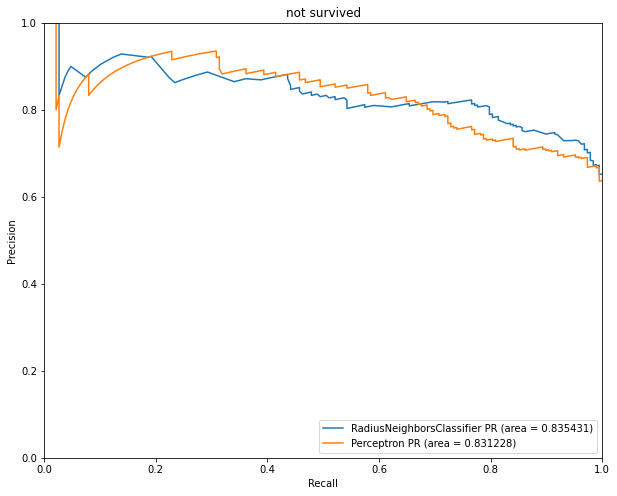

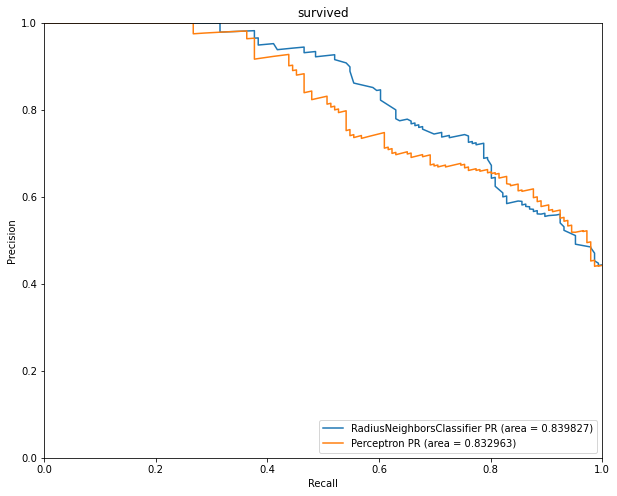

In [27]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
    
probas_rnc0 = rnc.fit(X_train, y_train).predict_proba (X_test)
probas_per0 = per.fit(X_train, y_train)._predict_proba_lr (X_test)
probas_rnc1 = rnc.fit(X_train, y_train).predict_proba (X_test)
probas_per1 = per.fit(X_train, y_train)._predict_proba_lr(X_test)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_rnc1[:,0])
aps_rnc1 = average_precision_score(y_test_invers,probas_rnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_rnc1)) 
# персептрон
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_per1[:,0])
aps_per1 = average_precision_score(y_test_invers,probas_per1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('Perceptron',  aps_per1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not survived')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_rnc0[:,1])
aps_rnc0 = average_precision_score(y_test,probas_rnc0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_rnc0)) 
# персептрон
precision, recall, thresholds = precision_recall_curve(y_test, probas_per1[:,1])
aps_per0 = average_precision_score(y_test,probas_per0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('Perceptron',  aps_per0)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

### 9)Сравните кривые для классификаторов, указанных в задании, сделайте выводы

Линейный классификатор и k ближайших соседей имеют примерно одинаковые показатели качества относительно PR  кривых. В целом, данные классификаторы правильно решают задачу предсказания класса с вероятностью 0.8~0.85, что не слишком точно, но и далеко от случайного - 0.5 (т.к. классов всего 2). Поэтому задача классификации была решена.